# Notebook example on how to generate a SACC cluster number counts file

In this notebook, we generate random data of clusters inside a redshift and mass intervals, which will be stored in a SACC file. This notebook exemplifies the default way to provide a number counts SACC file to firecrown.

In [1]:
%load_ext autoreload
%autoreload 2
#!/usr/bin/env python

try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

import math
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import sys

sys.path.insert(0, "../../scripts")
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc

clmm.__version__
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import scipy.integrate
import astropy.units as u


Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

%matplotlib inline
catalog = "skysim5000_v1.1.1"
sys.path.insert(0, "/pbs/home/e/ebarroso/gcr-catalogs")
import GCRCatalogs

GCRCatalogs.set_root_dir_by_site("in2p3")
skysim_cat = GCRCatalogs.load_catalog(catalog)
cosmo_ss = skysim_cat.cosmology

# Generating data with NumCosmo

## Creating NumCosmo Mass function and Number Counts Object

In [2]:
print(cosmo_ss.H0, cosmo_ss.Om0)

71.0 km / (Mpc s) 0.2648


In [3]:
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()


cosmo.props.H0 = cosmo_ss.H0.value
cosmo.props.Omegab = cosmo_ss.Ob0
cosmo.props.Omegac = cosmo_ss.Odm0
cosmo.props.Omegax = cosmo_ss.Ode0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = cosmo_ss.n_s
print(cosmo_ss.sigma8, cosmo.sigma8(psf), cosmo.Omega_k0())

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log(
    (cosmo_ss.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))
print(
    cosmo_ss.H0.value,
    cosmo_ss.Ob0,
    cosmo_ss.Odm0,
    cosmo_ss.Ode,
    cosmo_ss.n_s,
    cosmo_ss.Neff,
)
print(cosmo.param_names())
print(cosmo.Omega_mnu0())
print()

0.8 0.8490796381176396 0.0
0.8 0.7999999999999999
71.0 0.0448 0.21999999999999997 <bound method FLRW.Ode of FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.2648, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)> 0.963 3.04
['H0', 'Omegac', 'Omegak', 'Tgamma0', 'Yp', 'ENnu', 'Omegab', 'w']
0.0



In [4]:
# Init and final redshift. Sky area
zl = 0.2
zu = 0.65
area = 439.78986
# Numcosmo Cluster Abundance

# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)


# Mass fuction definition
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster abundance obj, mass obj, redshift obj
ca = Nc.ClusterAbundance.new(hmf, None)
cluster_m = Nc.ClusterMass.new_from_name(
    "NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}"
    % (math.log(10) * np.log10(1e13), math.log(10) * np.log10(1e15))
)
cluster_z = Nc.ClusterRedshift.new_from_name(
    "NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (zl, zu)
)

ncount_nodist = Nc.DataClusterNCount.new(
    ca, "NcClusterRedshiftNodist", "NcClusterMassNodist"
)
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

## Generating Clusters 

In [5]:
rng = Ncm.RNG.seeded_new(None, 32)
ncount_nodist.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)
print(ncount_nodist.desc)

Cluster NCount resample unbinned. Generated 89401 from mean      89161 (full). Mass proxy type `NcClusterMassNodist', redshift proxy type `NcClusterRedshiftNodist'. Resampled in range [  0.2000,   0.6500] [1.00000000e+13, 1.00000000e+15] and area 439.7899 degrees square.


In [6]:
 ncount_nodist.catalog_save ("ncount_nodist32.fits", True)
ncount_nodist.catalog_load("ncount_nodist32.fits")

ncdata_fits = fits.open("ncount_nodist32.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
# ncdata_Table.sort('LNM_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.4285610549833374,30.255507852075702,0.4285610549833374,30.255507852075702
0.547082547647362,31.555589810758786,0.547082547647362,31.555589810758786
0.46818292662884137,31.393096588512037,0.46818292662884137,31.393096588512037
0.5089924211346762,30.9163464148807,0.5089924211346762,30.9163464148807
0.5604603014832846,31.049929670576997,0.5604603014832846,31.049929670576997
0.5222896848618753,30.066226408672655,0.5222896848618753,30.066226408672655
0.25500137707675935,30.585015664118146,0.25500137707675935,30.585015664118146
0.5126420412266512,30.310959393533135,0.5126420412266512,30.310959393533135
0.5803645711453446,33.169450212989204,0.5803645711453446,33.169450212989204


## Plot of Cluster Masses versus Redshift

89401


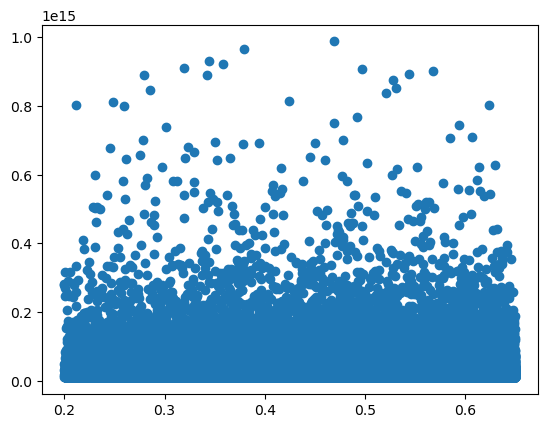

In [7]:
plt.scatter(ncdata_Table["Z_OBS"], np.exp(ncdata_Table["LNM_OBS"]))
print(len(ncdata_Table["Z_OBS"]))

## Plot of Cluster in bins of mass

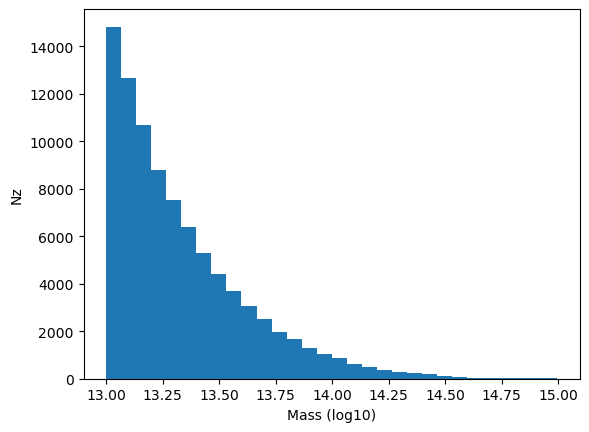

In [8]:
# Here we use the mass in log
img = plt.hist(np.log10(np.exp(ncdata_Table["LNM_OBS"])), bins=30)
plt.xlabel("Mass (log10)")
plt.ylabel("Nz")

# Saving In SACC Format

In [10]:
data_table = ncdata_Table
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]

cluster_z = np.array(cluster_z)
cluster_m = np.log10(np.exp(np.array(np.array(cluster_lnm))))
print(cluster_m)

[13.13980011 13.70441853 13.63384862 ... 13.07983363 13.22635392
 13.45195964]


[0.2000146  0.31251036 0.42500611 0.53750187 0.64999763] [13.00000141 13.39889424 13.79778706 14.19667989 14.59557271 14.99446554]
89401.0


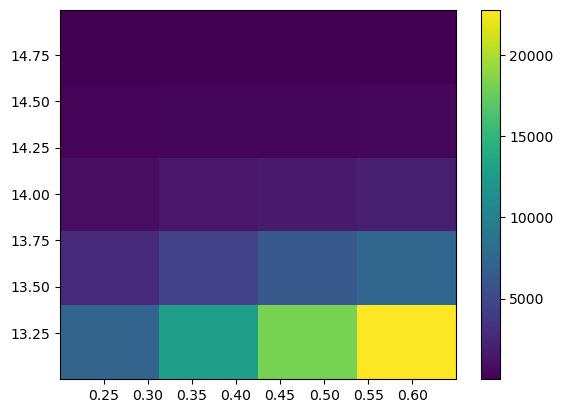

In [11]:
N_m = 5  # number of mass bins
N_z = 4  # number of redshift bins

data_lz, z_edges, m_edges, im = plt.hist2d(cluster_z, (cluster_m), bins=[N_z, N_m])


print(z_edges, m_edges)
print(np.sum(data_lz))
plt.colorbar()

Next, we create a covariance for the data, which should be a `numpy.ndarray`. We are using only Shot Noise.

[[ 7251.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.  2713.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.   897.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.   216.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.    35.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0. 12735.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.  4512.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0. 

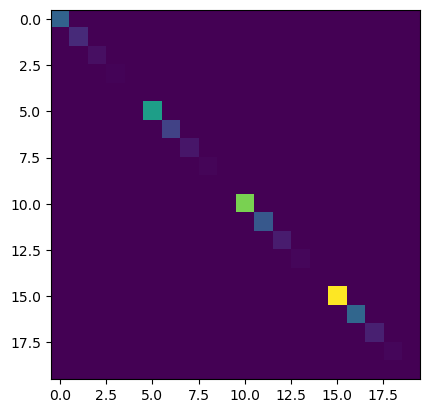

In [12]:
covariance = np.zeros((N_m * N_z, N_m * N_z))
np.fill_diagonal(covariance, (data_lz.flatten()))


plt.imshow((covariance))
print(covariance)

## Storing In Sacc
We first initialize the SACC object and name as `s_count`. The file must have at least one tracer from the supported types, which shall be called `cluster_counts_true_mass`. So far, firecrown only has the implementation for real mass and real redshift. More options will be provided in the future. The tracer must be added as being the type `misc` and should be created with a directory to be added under `metadata`.

The metadata dictionary must be created with:
 * `Mproxy_type: 'true_mass'`. A `str` that represents the type of proxy. So far there is only the `true_mass` option.
 * `Mproxy_edges : m_edges`. A `numpy.array` of `floats` with the proxy bins.
 * `z_type : 'true_redshift'`. A string that represents the type of redshift. So far there is only the `true_redshift` option.
 * `z_edges : z_edges`. A `numpy.array` of `floats` with the redshift bins.
 * `sky_area: 439.78986`. A `float` with the sky area.  

With the metadata, the `add_tracer` function must be called

In [13]:
s_count = sacc.Sacc()

In [14]:
name = f"cluster_counts_true_mass"
metadata = {
    "Mproxy_type": "true_mass",
    "Mproxy_edges": np.array(m_edges),
    "z_type": "true_redshift",
    "z_edges": np.array(z_edges),
    "sky_area": area,
}
s_count.add_tracer("misc", name, metadata=metadata)

Having the tracer, the user must call the `add_data` function for all the data points using the same tracer. The data should be the number of clusters in each bin of redsfhit and proxy. The order of the data is really important: the user must add the data  for each redshift bin iterating then over the proxy bins, that is, filling a row-major (z, proxy) matrix. 

In [15]:
# One of our identifiers is a standard type name that is predefined
cluster_count = sacc.standard_types.cluster_mass_count_wl
for i in range(N_z):
    for j in range(N_m):
        # Cluster number counts data
        tracer = name
        value = data_lz[i][j]
        s_count.add_data_point(cluster_count, (tracer,), value, err=1.0)

Lastly, the user must add the covariance and call the necessary functions to save the SACC file.

In [16]:
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("clusters_numcosmo_seed32.sacc", overwrite=True)